In [2]:
import pandas as pd
import numpy as np

# Logistic regression
from sklearn.linear_model import LogisticRegression

#Bagging
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

from utils import evaluate

## Modelado

In [3]:
X_train = pd.read_parquet('../data/X_train.parquet')
y_train = pd.read_parquet('../data/y_train.parquet')

X_test  = pd.read_parquet('../data/X_test.parquet')
y_test  = pd.read_parquet('../data/y_test.parquet')

y_train = y_train['DEATH_EVENT']
y_test  = y_test['DEATH_EVENT']

In [4]:
features_selected = ['serum_sodium', 
                     'platelets', 
                     'creatinine_phosphokinase', 
                     'age',
                     'ejection_fraction',
                     'serum_creatinine'
                    ]

X_train = X_train.loc[: , features_selected]
X_test = X_test.loc[: , features_selected]

In [20]:
# X_train = X_train.drop(columns = ['time'])
# X_test  = X_test.drop(columns = ['time'])

## Tuneo Bagging

In [9]:
seed = 8
tree = DecisionTreeClassifier()
num_trees = 500

model_bagg = BaggingClassifier(base_estimator = tree,
                              n_estimators = num_trees,
                              random_state = seed)

In [10]:
model   = model_bagg
scoring = {'recall': 'recall',
           'precision': 'precision',
           'f1': 'f1'}

grid = {'base_estimator__max_depth': np.arange(2, 7, 1),
        'base_estimator__min_samples_leaf': np.arange(10, 41, 5)}

grid_search = GridSearchCV(estimator = model, 
                           param_grid = grid, 
                           n_jobs = -1,
                           cv = 5,
                           scoring = scoring,
                           refit = 'precision'
                           )

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                         n_estimators=500, random_state=8),
             n_jobs=-1,
             param_grid={'base_estimator__max_depth': array([2, 3, 4, 5, 6]),
                         'base_estimator__min_samples_leaf': array([10, 15, 20, 25, 30, 35, 40])},
             refit='precision',
             scoring={'f1': 'f1', 'precision': 'precision', 'recall': 'recall'})

In [11]:
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))

Best: 0.850000 using {'base_estimator__max_depth': 2, 'base_estimator__min_samples_leaf': 15}


In [12]:
seed = 8
tree = DecisionTreeClassifier(max_depth = 2,
                              min_samples_leaf = 15)
num_trees = 500

bag = BaggingClassifier(base_estimator = tree,
                        n_estimators = num_trees,
                        random_state = seed)

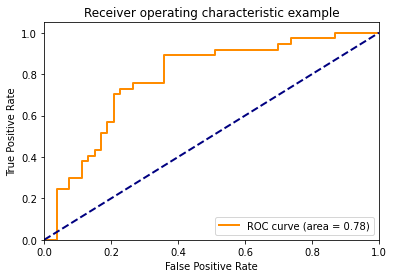

{'recall': 0.2972972972972973,
 'precision': 0.6470588235294118,
 'f1': 0.40740740740740744,
 'accuracy': 0.6444444444444445,
 'auc': 0.7802141764405917}

In [13]:
bag.fit(X_train, y_train)

y_pred  = bag.predict(X_test)
y_proba = bag.predict_proba(X_test)[:,1]
evaluate(y_test, y_pred, y_proba)

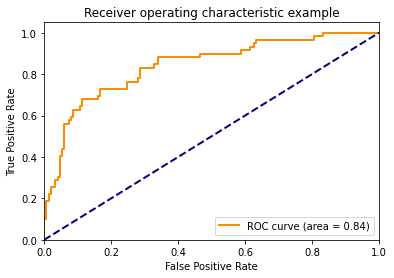

{'recall': 0.4067796610169492,
 'precision': 0.7741935483870968,
 'f1': 0.5333333333333334,
 'accuracy': 0.7990430622009569,
 'auc': 0.8411299435028249}

In [14]:
y_pred  = bag.predict(X_train)
y_proba = bag.predict_proba(X_train)[:,1]
evaluate(y_train, y_pred, y_proba)

In [15]:
# Guardando el modelo
import joblib
joblib.dump(bag, '../models/bagging_tree.pkl')

['../models/bagging_tree.pkl']